In [1]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt


### I approached this problem as a ranking issue based on whether users viewed product details in certain categories during a session. In other words, I created a dataset where if a user viewed the details of a product in a category during a session, it was marked as 1, otherwise as 0. I then ranked the categories within session ID groups and recommended the categories that were ranked highest.

In [2]:
# Reading the dataset and sorting it for proper feature engineering.
df = pd.read_parquet("/kaggle/input/insider-case-dataset/train.parquet")
df.sort_values(["userId", "date"],inplace=True, ignore_index=True)

In [3]:
#extracting the lists from string expression to correctly handling category column.

# Function to convert string to list
def convert_to_list(item):
    try:
        return ast.literal_eval(item)
    except (ValueError, SyntaxError):
        return []

# Apply the conversion function
df['category'] = df['category'].apply(convert_to_list)

#extracting the category names as string inside lists. If the list is empty it is replaced with "-"
def create_string(lst):
    return ', '.join(lst) if lst else '-'

# Apply the string creation function
df['category'] = df['category'].apply(create_string)

### Feature Engieering

In [4]:
df["cost_change"] = np.log1p(df["oldProductPrice"])-np.log1p(df["productPrice"])

#Creating boolean columns to detect if a user clicked the product detail, success and cart page or not to create user based aggregated time series features
df["page_view_bool"] = 0
df.loc[df["pageType"]=="productDetail", "page_view_bool"] = 1

df["success_bool"] = 0
df.loc[df["pageType"]=="success", "success_bool"] = 1

df["cart_bool"] = 0
df.loc[df["pageType"]=="cart", "cart_bool"] = 1

In [5]:
# Having some aggregations to extract knowledge from previous sessions of users.
session_activity_counts = df.groupby(["userId","sessionId"],as_index=False).size()
session_activity_counts.rename(columns={"size":"all_session_actions_feature"},inplace=True)
session_page_view_agg = df.groupby(["userId","sessionId"],as_index=False)["page_view_bool"].mean()
session_page_view_agg.rename(columns={"page_view_bool":"session_page_views_feature"},inplace=True)
session_success_agg = df.groupby(["userId","sessionId"],as_index=False)["success_bool"].mean()
session_success_agg.rename(columns={"success_bool":"session_success_feature"},inplace=True)

session_cart_agg = df.groupby(["userId","sessionId"],as_index=False)["cart_bool"].mean()
session_cart_agg.rename(columns={"cart_bool":"session_cart_feature"},inplace=True)

session_cost_change_agg = df.groupby(["userId","sessionId"],as_index=False)["cost_change"].mean()
session_cost_change_agg.rename(columns={"cost_change":"session_cost_change_feature"},inplace=True)


In [6]:
# Calculating lags and lagged rolling averages of the aggregations to prevent data leakage.
session_activity_counts["all_session_actions_feature_lag_1"] = session_activity_counts.groupby("userId")["all_session_actions_feature"].shift(1).fillna(0)
session_activity_counts["all_session_actions_feature_lag_1_rolling_3_mean"] = session_activity_counts.groupby("userId")["all_session_actions_feature_lag_1"].rolling(3, min_periods=1).mean().reset_index(drop=True)

session_page_view_agg["session_page_views_feature_lag_1"] = session_page_view_agg.groupby("userId")["session_page_views_feature"].shift(1).fillna(0)
session_page_view_agg["session_page_views_feature_lag_1_rolling_3_mean"] = session_page_view_agg.groupby("userId")["session_page_views_feature_lag_1"].rolling(3, min_periods=1).mean().reset_index(drop=True)

session_success_agg["session_success_feature_lag_1"] = session_success_agg.groupby("userId")["session_success_feature"].shift(1).fillna(0)
session_success_agg["session_success_feature_lag_1_rolling_3_mean"] = session_success_agg.groupby("userId")["session_success_feature_lag_1"].rolling(3, min_periods=1).mean().reset_index(drop=True)

session_cart_agg["session_cart_feature_lag_1"] = session_cart_agg.groupby("userId")["session_cart_feature"].shift(1).fillna(0)
session_cart_agg["session_cart_feature_lag_1_rolling_3_mean"] = session_cart_agg.groupby("userId")["session_cart_feature_lag_1"].rolling(3, min_periods=1).mean().reset_index(drop=True)


session_cost_change_agg["session_cost_change_feature_lag_1"] = session_cost_change_agg.groupby("userId")["session_cost_change_feature"].shift(1).fillna(0)
session_cost_change_agg["session_cost_change_feature_lag_1_rolling_3_mean"] = session_cost_change_agg.groupby("userId")["session_cost_change_feature_lag_1"].rolling(3, min_periods=1).mean().reset_index(drop=True)

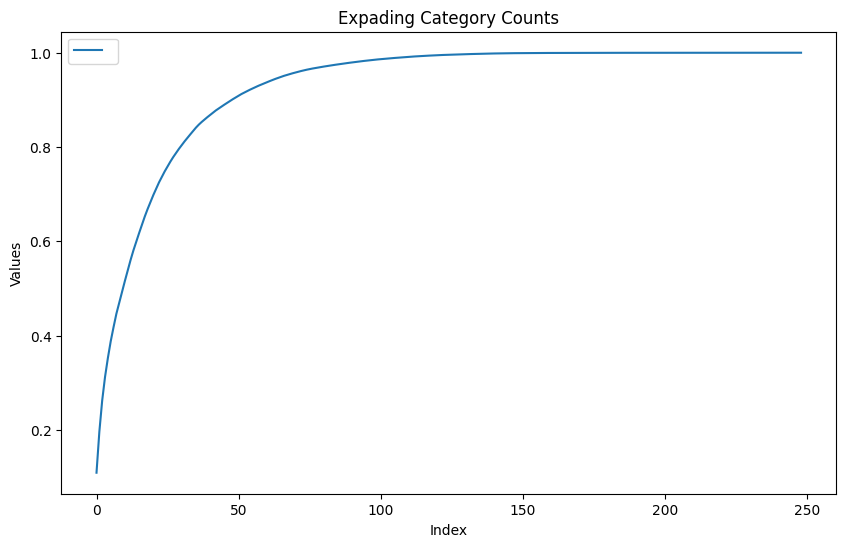

In [7]:

#For simplicity I wanted to use the most frequent categories which are able to conver almost 99% of the dataset.

# Plot the Series
plt.figure(figsize=(10, 6))
pd.Series(df[df["category"]!="-"]["category"].value_counts(normalize=True).expanding().sum().values).plot(title='Expading Category Counts', legend=True)
plt.xlabel('Index')
plt.ylabel('Values')
plt.show()


# I selected the number as 100 by considering the figure
top_100_categories = df[df["category"]!="-"]["category"].value_counts(normalize=True).index[:100].to_list()

In [8]:
# Filtering all positive examples to start building the training dataset. If there is no product detail click in a single sesssion there is no point for ranking.
cond1 = df["pageType"]=="productDetail"
train = df[cond1].copy()

In [9]:
# Aggregations based on ["userId","sessionId","category"] to obtain how many product detail clicks each category has received 

train_grp = train[["userId","sessionId","category","itemId"]].groupby(["userId","sessionId","category"], as_index=False).agg({
     "itemId":["nunique"]
})


train_grp.columns = [ "userId","sessionId", "category", "itemId_nunique"]


In [10]:
train_grp

,userId,sessionId,category,itemId_nunique
0,0001d86ea81e6eef12cebaa1dcbdadc2,06682b9d75eaa78be62b2be307ac7b683191169acec7ad...,"kadın ayakkabi, terlik",1
1,000a53fe09a2a3decd11b6b30d703b9c,039a27cc12b7e96e7b6c1451f9afbbd26c4b033f8d04d3...,"erkek ayakkabı, klasik ayakkabı",2
2,000a53fe09a2a3decd11b6b30d703b9c,2b5cceaf893bffa49656d179dab5cd589322d6fb47b91f...,"erkek ayakkabı, klasik ayakkabı",1
3,000a53fe09a2a3decd11b6b30d703b9c,2b5cceaf893bffa49656d179dab5cd589322d6fb47b91f...,"erkek ayakkabı, loafer",1
4,000a53fe09a2a3decd11b6b30d703b9c,e75f689b359c2adf0a71331dce21d6c9e56fdb360d107b...,"erkek ayakkabı, günlük ayakkabı",1
...,...,...,...,...
79206,fff50b42b75dcd43904f5957e27f313a,ef4031d5c3dd1ca7b81c79ac1f1c466dd8fb7f3970bcfb...,"erkek deri giyim, deri ceket",1
79207,fff50b42b75dcd43904f5957e27f313a,ef4031d5c3dd1ca7b81c79ac1f1c466dd8fb7f3970bcfb...,"erkek deri giyim, deri kaban",1
79208,fff50b42b75dcd43904f5957e27f313a,ef4031d5c3dd1ca7b81c79ac1f1c466dd8fb7f3970bcfb...,"erkek deri giyim, deri mont",2
79209,fffbf34dc7731aa74a5c29ddd3de1c94,b022fb7b34d6676a75342b0b28456f84ef1b361d2777e8...,"kadın çanta, omuz askılı çanta",1


### Negative Sampling

In [11]:
# Until now we only considered positive samples which mean all categories having some amount of detail views. To implement ranking we should upsample the dataset
# for never seen categories for each session.


# Create a DataFrame with unique userId and sessionId
unique_sessions = train_grp[['userId', 'sessionId']].drop_duplicates().reset_index(drop=True)

# Create negative samples for each unique session
negative_samples = [
    pd.DataFrame({
        'userId': user,
        'sessionId': session,
        'category': top_100_categories,
        'itemId_nunique': 0
    })
    for user, session in zip(unique_sessions['userId'], unique_sessions['sessionId'])
]
# Concatenate all negative samples and the original train_grp
full_train = pd.concat([train_grp] + negative_samples, ignore_index=True)


In [12]:
# Above we added already seen category instances too. We should remove the new added(negative ones) by dropping duplicates.
full_train.drop_duplicates(["userId","sessionId","category"], keep="first", ignore_index=True,inplace=True)

In [13]:
#sorting all sessions to make sure to keep time series structure and ranking groups.

order_category = train_grp["userId"].drop_duplicates().values
order_subcategory = train_grp["sessionId"].drop_duplicates().values


full_train['userId'] = pd.Categorical(full_train['userId'], categories=order_category, ordered=True)
full_train['sessionId'] = pd.Categorical(full_train['sessionId'], categories=order_subcategory, ordered=True)

# Sort the DataFrame by 'Category' and then 'Subcategory'
full_train = full_train.sort_values(['userId', 'sessionId'])

In [14]:
full_train

,userId,sessionId,category,itemId_nunique
0,0001d86ea81e6eef12cebaa1dcbdadc2,06682b9d75eaa78be62b2be307ac7b683191169acec7ad...,"kadın ayakkabi, terlik",1
79211,0001d86ea81e6eef12cebaa1dcbdadc2,06682b9d75eaa78be62b2be307ac7b683191169acec7ad...,"kadın ayakkabi, sandalet",0
79212,0001d86ea81e6eef12cebaa1dcbdadc2,06682b9d75eaa78be62b2be307ac7b683191169acec7ad...,kadın ayakkabi,0
79213,0001d86ea81e6eef12cebaa1dcbdadc2,06682b9d75eaa78be62b2be307ac7b683191169acec7ad...,"kadın ayakkabi, günlük ayakkabı",0
79214,0001d86ea81e6eef12cebaa1dcbdadc2,06682b9d75eaa78be62b2be307ac7b683191169acec7ad...,"erkek ayakkabı, günlük ayakkabı",0
...,...,...,...,...
5519813,fffbf34dc7731aa74a5c29ddd3de1c94,fb0721e8c3cc87f9010cd73f9f050d4fa9f5b3298fc383...,list,0
5519814,fffbf34dc7731aa74a5c29ddd3de1c94,fb0721e8c3cc87f9010cd73f9f050d4fa9f5b3298fc383...,bodrum sandaletleri,0
5519815,fffbf34dc7731aa74a5c29ddd3de1c94,fb0721e8c3cc87f9010cd73f9f050d4fa9f5b3298fc383...,"kadın deri giyim, deri elbise",0
5519816,fffbf34dc7731aa74a5c29ddd3de1c94,fb0721e8c3cc87f9010cd73f9f050d4fa9f5b3298fc383...,"erkek deri giyim, deri yelek",0


In [15]:
# merging previously created features to train data.

final_train = full_train.merge(session_activity_counts, on=["userId","sessionId"], how="left", validate="many_to_one")
final_train = final_train.merge(session_page_view_agg, on=["userId","sessionId"], how="left", validate="many_to_one")
final_train = final_train.merge(session_success_agg, on=["userId","sessionId"], how="left", validate="many_to_one")
final_train = final_train.merge(session_cart_agg, on=["userId","sessionId"], how="left", validate="many_to_one")
final_train = final_train.merge(session_cost_change_agg, on=["userId","sessionId"], how="left", validate="many_to_one")

In [16]:
feature_set = ['all_session_actions_feature', 'all_session_actions_feature_lag_1',
       'all_session_actions_feature_lag_1_rolling_3_mean', 'session_page_views_feature',
       'session_page_views_feature_lag_1',
       'session_page_views_feature_lag_1_rolling_3_mean',
       'session_success_feature', 'session_success_feature_lag_1',
       'session_success_feature_lag_1_rolling_3_mean', 'session_cart_feature',
       'session_cart_feature_lag_1',
       'session_cart_feature_lag_1_rolling_3_mean',
       'session_cost_change_feature', 'session_cost_change_feature_lag_1',
       'session_cost_change_feature_lag_1_rolling_3_mean']

In [17]:
#converting the number of click for different product for each category to binary values.
# There might be different approaches like quantile cut to have more than 2 levels.
final_train["target"] = final_train["itemId_nunique"].apply(lambda x:1 if x>0 else 0)

### Model Training

In [18]:
# Model training part. using group k fold on sessionId groups because it is not desired to make any predictions during the session. The predictions should be made
# for the next session just after the current session is over.

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold

early_stopping = lgb.early_stopping(stopping_rounds=10, verbose=True)
log_evaluation = lgb.log_evaluation(period=10)

gkf = GroupKFold(n_splits=5)

# Split the data using GroupKFold
for train_index, test_index in gkf.split(final_train.index, final_train["target"], final_train["sessionId"]):
    train = final_train.loc[train_index]
    test = final_train.loc[test_index]
    group_train = train.groupby('sessionId').size().to_list()
    group_test = test.groupby('sessionId').size().to_list()
    X_train, X_test = train[feature_set], test[feature_set]
    y_train, y_test = train["target"], test["target"]
    # Setup the LightGBM Ranker
    ranker = lgb.LGBMRanker(
        objective='lambdarank',
        metric='ndcg',
        num_leaves=31,
        verbose=-1,
        learning_rate=0.05,
        n_estimators=100
    )

    # Train the model
    ranker.fit(X_train, y_train, group=group_train,
               eval_set=[(X_test, y_test)],
               eval_group=[group_test],
               eval_at=[1, 3, 5],  # Evaluation positions
               callbacks=[early_stopping, log_evaluation]
               )
    # Getting the out of fold predictions for all data.
    final_train.loc[test_index,"oof_predictions"] = ranker.predict(X_test)

Training until validation scores don't improve for 10 rounds
[10]	valid_0's ndcg@1: 0.502084	valid_0's ndcg@3: 0.506711	valid_0's ndcg@5: 0.514147
[20]	valid_0's ndcg@1: 0.510872	valid_0's ndcg@3: 0.515316	valid_0's ndcg@5: 0.522744
[30]	valid_0's ndcg@1: 0.51368	valid_0's ndcg@3: 0.518085	valid_0's ndcg@5: 0.525577
[40]	valid_0's ndcg@1: 0.518663	valid_0's ndcg@3: 0.522995	valid_0's ndcg@5: 0.530432
[50]	valid_0's ndcg@1: 0.520747	valid_0's ndcg@3: 0.525016	valid_0's ndcg@5: 0.532496
[60]	valid_0's ndcg@1: 0.522921	valid_0's ndcg@3: 0.527139	valid_0's ndcg@5: 0.534624
[70]	valid_0's ndcg@1: 0.527994	valid_0's ndcg@3: 0.532167	valid_0's ndcg@5: 0.539619
[80]	valid_0's ndcg@1: 0.529716	valid_0's ndcg@3: 0.53384	valid_0's ndcg@5: 0.541313
[90]	valid_0's ndcg@1: 0.530169	valid_0's ndcg@3: 0.534293	valid_0's ndcg@5: 0.541625
Early stopping, best iteration is:
[88]	valid_0's ndcg@1: 0.53044	valid_0's ndcg@3: 0.53452	valid_0's ndcg@5: 0.541887
Training until validation scores don't improve f

In [19]:
# sorting each sessions predictions to see the rankings of categories
sorted_data = final_train.sort_values(['sessionId', 'oof_predictions'], ascending=[True, False],ignore_index=True)

In [20]:
# recommeding to 3 categories ranked by the model.
top_n = 3
recommendations = sorted_data.groupby('sessionId').head(top_n)

# Optionally, you can filter out only the necessary columns
recommendations = recommendations[['sessionId', 'category', 'oof_predictions']]

# Display or use the recommendations


In [21]:
# Lastly training a single model using all data to have the best performance.

In [22]:
group_train = final_train.groupby('sessionId').size().to_list()


ranker = lgb.LGBMRanker(
    objective='lambdarank',
    metric='ndcg',
    num_leaves=31,
    verbose=-1,
    learning_rate=0.05,
    n_estimators=100
)

# Train the model
ranker.fit(final_train[feature_set], final_train["target"], group=group_train,
           )

LGBMRanker(learning_rate=0.05, metric='ndcg', objective='lambdarank',
           verbose=-1)

In [23]:
# model is saved to be used in the api to make recommendations
model_path = 'ranking_model.lgb'
ranker.booster_.save_model(model_path)
print(f'Model saved to {model_path}')

Model saved to ranking_model.lgb
